In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_colwidth', 1000)

In [2]:
df = pd.DataFrame()
for i in range(1,5):
    file_name = 'data/data_' + str(i) + '.csv'
    df_data = pd.read_csv(file_name)
    df = df.append(df_data)
df = df.reset_index(drop=True)

In [3]:
def remove_terms(tweet, keyword, character):
    if keyword:
        for i in keyword:       
            tweet = tweet.replace(character+i.lower(),'')
    return tweet

In [4]:
# Removing some columns about user information
df = df.drop(columns=['date','link','hour','username','name_x','retweet','location'])

# 'tweets' column to lowercase
df['tweet'] = df['tweet'].str.lower()

# Transform the data type of some columns
df['label'] = df['label'].astype(int)

# Transform object type to list
df['hashtags'] = df['hashtags'].apply(lambda x: x.strip('][').split(', ') if x != '[]' else 0)
df['hashtags'] = df['hashtags'].apply(lambda x:[item.strip("'") for item in x] if x != 0 else 0)
screen_name = re.compile("screen_name': '(\w+)'")
df['reply_to'] = df['reply_to'].apply(lambda x:screen_name.findall(x))

# Remove hashtags and reply_to from tweet
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['hashtags'],'#'), axis=1)
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['reply_to'],'@'), axis=1)

# Add a column about 'mention'
screen_name = re.compile("@(\w+)")
df['mention'] = df['tweet'].apply(lambda x:screen_name.findall(x))

# Remove mention from tweet
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['mention'],'@'), axis=1)

# Transform 'reply_to' and 'mention' to int
df['reply_to'] = df['reply_to'].apply(lambda x:len(x) if x != '[]' else 0)
df['mention'] = df['mention'].apply(lambda x:len(x) if x != '[]' else 0)

# Remove photos and video link from tweet
df['tweet'] = df['tweet'].apply(lambda x:re.sub('https://[a-z./0-9]+', '', x))
df['tweet'] = df['tweet'].str.strip()

# Add a column about tweet length
df['tweet_length'] = df['tweet'].apply(lambda x:len(x.split()))

# quote_url is when people quote other's tweets in their tweets.
# Assuming that people quote others tweet is for commenting, not tend to have suicidality
df['quote_url'] = df['quote_url'].astype(str)
df['quote_url'] = df['quote_url'].apply(lambda x: 0 if x=="0" or x=='nan' else 1)

# 'Bio' has NaN value
df['bio'] = df['bio'].replace('\n',' ',regex=True)
df['bio'] = df['bio'].replace('\r',' ',regex=True)

# urls,photos will be classified as 0 or 1
df['urls'] = df['urls'].apply(lambda x: 0 if x == "[]" else 1)
df['photos'] = df['photos'].apply(lambda x: 0 if x == "[]" else 1)

# 'url' is when people put some link on their user profile
df['url'] = df['url'].astype(str)
df['url'] = df['url'].apply(lambda x: 0 if x == 'nan' else 1)

# Concatenate the sentimental analysis
df_data = pd.read_csv('data/tweets_sentiment_result.csv')
df_data.columns = ['tweet_sentiment','tweet']
df['tweet_sentiment'] = df_data['tweet_sentiment']

df_data = pd.read_csv('data/bio_sentiment_result.csv')
df_data.columns = ['bio_sentiment','bio']
df['bio_sentiment'] = df_data['bio_sentiment']

# Drop 'bio'
df = df.drop(columns=['bio'])

In [5]:
# investigating 'hashtags'
lst = []
for element in df['hashtags']:
    if element != 0:
        lst += element
hashtags = pd.DataFrame(lst)
hashtags.value_counts().head(5)

mentalhealth                  48
suicidal                      45
turkishstudentslivesmatter    29
suicideprevention             28
depression                    24
dtype: int64

For tweets having suicidal label,  97% of them don't have hashtags.  
We can assume usually people want to raise awareness about suicide may put hashtags.  
Therefore it would be safe to only put numbers of hashtags as feature.  

In [6]:
df['hashtags'] = df['hashtags'].apply(lambda x:len(x) if x != 0 else 0)

#### The pronouns of a tweet
When a tweet is using first-person point of view, it's more likely to refer to the tweet owner's personal feeling, therefore, more likely to be real suicidal thoughts.  
Whereas tweets in second/third person point of view are more like people describing other events.  

In [7]:
first_person = ['i', 'my', 'me', 'am']
df['first_person'] = 0
for word in first_person:
    word_ = re.compile('(^|\s)' + word + '($|\s)')
    first_person_lst = df['tweet'].apply(lambda x:1 if len(word_.findall(x)) > 0 else 0)
    df['first_person'] = df['first_person'] + first_person_lst

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9150 entries, 0 to 9149
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             9150 non-null   object
 1   label             9150 non-null   int64 
 2   hashtags          9150 non-null   int64 
 3   day               9150 non-null   int64 
 4   urls              9150 non-null   int64 
 5   photos            9150 non-null   int64 
 6   video             9150 non-null   int64 
 7   nlikes            9150 non-null   int64 
 8   nreplies          9150 non-null   int64 
 9   nretweets         9150 non-null   int64 
 10  quote_url         9150 non-null   int64 
 11  reply_to          9150 non-null   int64 
 12  url               9150 non-null   int64 
 13  join_date         9150 non-null   object
 14  join_time         9150 non-null   object
 15  tweets            9150 non-null   int64 
 16  following         9150 non-null   int64 
 17  followers     

### Feature Engineering

In [9]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Adding a list of stop words to the wordlist
my_stop_words = text.ENGLISH_STOP_WORDS.union(['suicidal','bc','did','didn','t','does','doesn','don','dont','doing','going','gonna','having','isn','ve','wanna','want','wanted','wanting','wasn','went','yes','yeah'])
count_vectorizer = CountVectorizer(min_df=0.01, max_df=0.5, stop_words=my_stop_words)
count_vectorizer.fit_transform(df[df['label'] == 2]['tweet'])
dic = count_vectorizer.vocabulary_

In [10]:
pd.DataFrame(dic.items()).sort_values(1,ascending=False)[:10]

,0,1
111,years,150
78,year,149
114,wrong,148
148,worse,147
17,world,146
102,work,145
118,won,144
144,wish,143
142,weeks,142
109,week,141


<AxesSubplot:title={'center':'Not Suicidal People by day'}>

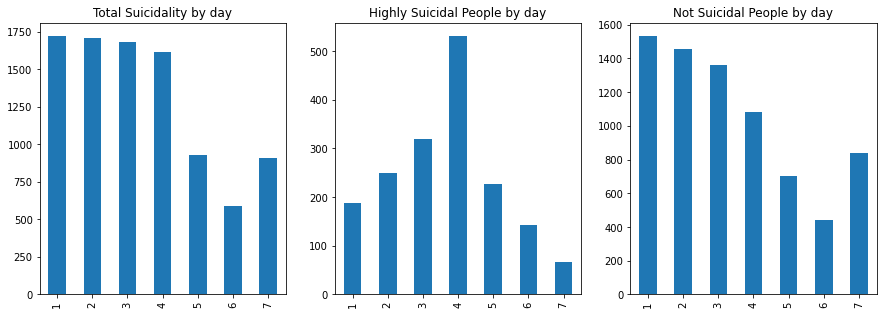

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Total Suicidality by day')
df['day'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,3,2)
plt.title('Highly Suicidal People by day')
df[df['label'] == 2]['day'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,3,3)
plt.title('Not Suicidal People by day')
df[df['label'] != 2]['day'].value_counts().sort_index().plot(kind='bar')

Interesting, how come on Thursday suicidal vibe is so strong?  
We can use the absolute value to map this tendency.  

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = preprocessing.MinMaxScaler()
new_df = MinMaxScaler().fit_transform(df[columns_to_scale])
new_df= pd.DataFrame(new_df, columns=columns_to_scale)
for c in columns_to_scale:
    df[c] = new_df[c]

#### Reference: Sentiment analysis through Sentiment140 API

In [ ]:
# Save 'tweet' and 'bio' for sentiment analysis
df['tweet'].to_csv('data/tweets_for_sentiment.txt',index=False)
df['bio'].to_csv('data/bio_for_sentiment.txt',index=False)

In [ ]:
! curl --data-binary @data/tweets_for_sentiment.txt "http://www.sentiment140.com/api/bulkClassify?appid=feixie.2020@mitb.smu.edu.sg" > 'data/tweets_sentiment_result.csv'
! curl --data-binary @data/bio_for_sentiment.txt "http://www.sentiment140.com/api/bulkClassify?appid=feixie.2020@mitb.smu.edu.sg" > 'data/bio_sentiment_result.csv'